---
title: "Module 05: Lab 02"
subtitle: "Regression Modeling on Employment Data"
author:
  - name: Norah Jones
    affiliations:
      - id: cmu
        name: Carnegie Mellon University
        city: Pittsburgh
        state: PA
      - id: chicago
        name: University of Chicago
        city: Chicago
        state: IL
  - name: John Hamm
    affiliations:
      - ref: cmu
      - name: University of California, San Diego
        city: San Diego
        state: CA
number-sections: true
date: "2024-11-21"
format:
  html:
    theme: cerulean
    toc: true
    toc-depth: 2
date-modified: today
date-format: long
execute: 
  echo: false
  eval: false
  freeze: auto
---

# Objectives {.unnumbered}

1. Use **PySpark** to process the Lightcast dataset.
2. Engineer features from structured columns for salary prediction.
3. Train **Linear Regression model**.
4. Evaluate models using **RMSE** and **R²**.
5. Visualize predictions using diagnostic plots.
6. Push work to GitHub and submit the repository link.

# Setup {.unnumbered}

The instruction below provides you with general keywords for columns used in the lightcast file. See the data schema generated after the load dataset code above to use proper column name. For visualizations, tables, or summaries, please **customize colors, fonts, and styles** as appropriate to avoid a **2.5-point deduction**. Also, **provide a two-sentence explanation** describing key insights drawn from each section's code and outputs. 

1. Follow the steps below as necessary, use your best judgement in importing/installing/creating/saving files as needed.
2. Create a new Jupyter Notebook in your `ad688-sp25-lab08` directory named `lab08_yourname.ipynb`, if the file exists make sure to change the name.
3. Use your **EC2 instance** for this lab.
4. Ensure the `lightcast_data.csv` file is available on the EC2 instance. if not then **Download the dataset**
5. **Add the dataset to `.gitignore`** to avoid pushing large files to GitHub. Open your `.gitignore` file and add:
6. Make sure to create a virtual environment and install the required Python libraries if needed, don't forget to activate it:
7. Install the required Python libraries if needed, you can also use the given requirement file to install the packages to the virtual environment:

```bash
python3 -m venv .venv
source .venv/bin/activate
gdown https://drive.google.com/uc?id=1V2GCHGt2dkFGqVBeoUFckU4IhUgk4ocQ
echo "lightcast_job_postings.csv" >> .gitignore
pip install -r requirements.txt
```


# Load the Dataset
1. **Load the Raw Dataset**:
   - Use Pyspark to the `lightcast_data.csv` file into a DataFrame:
   - You can reuse the previous code. 
   - [Copying code from your friend constitutes plagiarism. DO NOT DO THIS]{.uured-bold}.

In [19]:
#| eval: true
#| echo: true
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("lightcast_job_postings.csv")

# Show Schema and Sample Data
print("---This is Diagnostic check, No need to print it in the final doc---")

df.printSchema() # comment this line when rendering the submission
df.show(5)

25/04/10 01:07:11 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
25/04/10 01:07:22 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


---This is Diagnostic check, No need to print it in the final doc---
root
 |-- ID: string (nullable = true)
 |-- LAST_UPDATED_DATE: date (nullable = true)
 |-- LAST_UPDATED_TIMESTAMP: timestamp (nullable = true)
 |-- DUPLICATES: integer (nullable = true)
 |-- POSTED: date (nullable = true)
 |-- EXPIRED: date (nullable = true)
 |-- DURATION: integer (nullable = true)
 |-- SOURCE_TYPES: string (nullable = true)
 |-- SOURCES: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- ACTIVE_URLS: string (nullable = true)
 |-- ACTIVE_SOURCES_INFO: string (nullable = true)
 |-- TITLE_RAW: string (nullable = true)
 |-- BODY: string (nullable = true)
 |-- MODELED_EXPIRED: date (nullable = true)
 |-- MODELED_DURATION: integer (nullable = true)
 |-- COMPANY: integer (nullable = true)
 |-- COMPANY_NAME: string (nullable = true)
 |-- COMPANY_RAW: string (nullable = true)
 |-- COMPANY_IS_STAFFING: boolean (nullable = true)
 |-- EDUCATION_LEVELS: string (nullable = true)
 |-- EDUCATION_LEVELS

# Feature Engineering

Feature Engineering is a crucial step in preparing your data for machine learning. In this lab, we will focus on the following tasks:

1. **Drop rows with missing values** in the target variable and key features.
2. By now you are already familiar with the code and the data. Based on your understanding please choose any 3 (my code output has 10) variables as:
   1. two continuous variables (use your best judgment!)
   2. one categorical.
   3. Your dependent variable (y) is `SALARY`.
3. **Convert categorical variables** into numerical representations using **StringIndexer** and **OneHotEncoder**.
4. **Assemble features** into a single vector using **VectorAssembler**.
5. **Split the data** into training and testing sets.

In [20]:
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# 1. Drop rows with missing values in SALARY and key features
df = df.dropna(subset=["SALARY", "MIN_YEARS_EXPERIENCE", "MAX_YEARS_EXPERIENCE", "REMOTE_TYPE_NAME"])

# 2. Select features
continuous_cols = ["MIN_YEARS_EXPERIENCE", "MAX_YEARS_EXPERIENCE"]
categorical_cols = ["REMOTE_TYPE_NAME"]
target_col = "SALARY"

# 3. Convert categorical variables
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid='skip') 
            for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_vec") 
            for col in categorical_cols]

# 4. Assemble features
assembler = VectorAssembler(
    inputCols=continuous_cols + [f"{col}_vec" for col in categorical_cols],
    outputCol="features"
)

# 5. Create pipeline and transform data
pipeline = Pipeline(stages=indexers + encoders + [assembler])
model = pipeline.fit(df)
data = model.transform(df).select("SALARY", "features")

# Show the transformed data
data.show(5, False)

+------+---------------------+
|SALARY|features             |
+------+---------------------+
|92962 |[2.0,2.0,1.0,0.0,0.0]|
|75026 |[2.0,2.0,1.0,0.0,0.0]|
|60923 |[1.0,1.0,0.0,1.0,0.0]|
|131100|[2.0,2.0,1.0,0.0,0.0]|
|136950|[3.0,3.0,0.0,1.0,0.0]|
+------+---------------------+
only showing top 5 rows



In [ ]:
#| eval: false
#| echo: true
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

df = df.dropna(subset=[
                       ])

categorical_cols = [
                    ]

indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid='skip') for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_vec") for col in categorical_cols]

assembler = VectorAssembler(
    inputCols=[] + [f"{col}_vec" for col in categorical_cols],
    outputCol=""
)

pipeline = Pipeline(stages=indexers + encoders + [assembler])
data = 
data.show(5,False)

+------+-------------------------------------------------------+
|SALARY|features                                               |
+------+-------------------------------------------------------+
|131100|(186,[0,1,2,5,22,24,42],[2.0,2.0,11.0,1.0,1.0,1.0,1.0])|
|136950|(186,[0,1,2,9,22,25,34],[3.0,3.0,28.0,1.0,1.0,1.0,1.0])|
|136950|(186,[0,1,2,9,22,25,34],[3.0,3.0,28.0,1.0,1.0,1.0,1.0])|
|104000|(186,[0,1,2,5,22,24,41],[3.0,3.0,8.0,1.0,1.0,1.0,1.0]) |
|80000 |(186,[0,1,2,5,22,24,39],[3.0,3.0,37.0,1.0,1.0,1.0,1.0])|
+------+-------------------------------------------------------+
only showing top 5 rows



# Train/Test Split

- Perform a **random split** of the data into training and testing sets.
- Set a random seed for reproducibility.
- You can choose a number for splitting to your liking, justify your choice.

In [21]:
# Perform train/test split with 80/20 ratio
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Print the shapes of the resulting datasets
print("Training set dimensions:", (train_data.count(), len(train_data.columns)))
print("Testing set dimensions:", (test_data.count(), len(test_data.columns)))

Training set dimensions: (3060, 2)


Testing set dimensions: (696, 2)


In [11]:
#| eval: true
#| echo: false
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)
print((train_data.count(), len(train_data.columns)))
print((test_data.count(), len(test_data.columns)))

(1848, 2)
(395, 2)


# Linear Regression

- Train a **Linear Regression** model using the training data. [You will run in to an important issue here. Please make an effort in figuring it by yourself. This is one of the most asked interview questions in CapitalOne's management recruiting program.]{.uured-bold}
- Evaluate the model on the test data.
- Print the coefficients, intercept, R², RMSE, and MAE.
- Use the `summary` object to extract the coefficients and their standard errors, t-values, and p-values.
- Create a DataFrame to display the coefficients, standard errors, t-values, p-values, and confidence intervals.
- Interpret the coefficients and their significance and explain the model performance metrics.

In [22]:
from pyspark.ml.regression import LinearRegression
import pandas as pd

# Initialize and fit model with normal solver for statistics
lr = LinearRegression(featuresCol="features", labelCol="SALARY", solver="normal")
lr_model = lr.fit(train_data)
summary = lr_model.summary

# Performance metrics (always available)
print("\n--- Model Performance Metrics ---")
print(f"R-squared: {summary.r2:.4f}")
print(f"RMSE: {summary.rootMeanSquaredError:.4f}")
print(f"MAE: {summary.meanAbsoluteError:.4f}")

# Get feature names safely
try:
    num_features = len(lr_model.coefficients)
    feature_names = [f"feature_{i}" for i in range(num_features)]
    if 'assembler' in globals():
        input_cols = assembler.getInputCols()
        if len(input_cols) == num_features:
            feature_names = input_cols
except:
    feature_names = [f"feature_{i}" for i in range(len(lr_model.coefficients))]

# Create base coefficients DataFrame
coef_df = pd.DataFrame({
    'Feature': ['Intercept'] + feature_names,
    'Coefficient': [float(lr_model.intercept)] + [float(coef) for coef in lr_model.coefficients]
})

# Check if statistics are available
stats_available = False
try:
    # Test if statistics are accessible
    if hasattr(summary, 'coefficientStandardErrors'):
        _ = summary.coefficientStandardErrors  # This will raise the exception if not available
        stats_available = True
except:
    stats_available = False

# Add statistics if available
if stats_available:
    try:
        coef_df['Std Error'] = [0.0] + [float(x) for x in summary.coefficientStandardErrors]
        coef_df['t-value'] = [0.0] + [float(x) for x in summary.tValues]
        coef_df['p-value'] = [1.0] + [float(x) for x in summary.pValues]
        coef_df['CI_lower'] = coef_df['Coefficient'] - 1.96*coef_df['Std Error']
        coef_df['CI_upper'] = coef_df['Coefficient'] + 1.96*coef_df['Std Error']
    except Exception as e:
        print(f"\nCould not add statistics: {str(e)}")
else:
    print("\nNote: Coefficient statistics not available - using solver='normal' is required for standard errors")

print("\n--- Coefficients ---")
print(coef_df.to_string())

25/04/10 01:08:39 WARN Instrumentation: [7779f806] regParam is zero, which might cause numerical instability and overfitting.
25/04/10 01:08:49 WARN Instrumentation: [7779f806] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.



--- Model Performance Metrics ---
R-squared: 0.3351
RMSE: 29667.3160
MAE: 22791.1393

Note: Coefficient statistics not available - using solver='normal' is required for standard errors

--- Coefficients ---
     Feature   Coefficient
0  Intercept  61586.792042
1  feature_0   4388.351979
2  feature_1   4388.351979
3  feature_2  12744.205346
4  feature_3  19064.862003
5  feature_4   9219.585096


In [5]:
from pyspark.ml.regression import LinearRegression
import pandas as pd

# Initialize and fit model with normal solver for statistics
lr = LinearRegression(featuresCol="features", labelCol="SALARY", solver="normal")
lr_model = lr.fit(train_data)
summary = lr_model.summary

# Performance metrics (always available)
print("\n--- Model Performance Metrics ---")
print(f"R-squared: {summary.r2:.4f}")
print(f"RMSE: {summary.rootMeanSquaredError:.4f}")
print(f"MAE: {summary.meanAbsoluteError:.4f}")

# Get feature names safely
try:
    num_features = len(lr_model.coefficients)
    feature_names = [f"feature_{i}" for i in range(num_features)]
    if 'assembler' in globals():
        input_cols = assembler.getInputCols()
        if len(input_cols) == num_features:
            feature_names = input_cols
except Exception as e:
    print(f"Warning: Could not get feature names - {str(e)}")
    feature_names = [f"feature_{i}" for i in range(len(lr_model.coefficients))]

# Create base coefficients DataFrame
coef_df = pd.DataFrame({
    'Feature': ['Intercept'] + feature_names,
    'Coefficient': [float(lr_model.intercept)] + [float(coef) for coef in lr_model.coefficients]
})

# Check if statistics are available
stats_available = False
try:
    if hasattr(summary, 'coefficientStandardErrors'):
        _ = summary.coefficientStandardErrors  # Test access
        stats_available = True
except Exception as e:
    stats_available = False

# Add statistics if available
if stats_available:
    try:
        # Add statistical measures
        coef_df['Std Error'] = [0.0] + [float(x) for x in summary.coefficientStandardErrors]
        coef_df['t-value'] = [0.0] + [float(x) for x in summary.tValues]
        coef_df['p-value'] = [1.0] + [float(x) for x in summary.pValues]
        coef_df['CI_lower'] = coef_df['Coefficient'] - 1.96*coef_df['Std Error']
        coef_df['CI_upper'] = coef_df['Coefficient'] + 1.96*coef_df['Std Error']
        
        # Diagnostic length checks (matches CapitalOne example)
        print("\n--- Diagnostic Check ---")
        print(f"Length of features: {len(feature_names)}")
        print(f"Length of coefs: {len(lr_model.coefficients)}")
        print(f"Length of se: {len(summary.coefficientStandardErrors)}")
        print(f"Length of tvals: {len(summary.tValues)}")
        print(f"Length of pvals: {len(summary.pValues)}")
    except Exception as e:
        print(f"\nCould not add statistics: {str(e)}")
else:
    print("\nNote: Coefficient statistics not available - using solver='normal' is required for standard errors")

# Final output
print("\n--- Coefficients with Statistics ---")
print(coef_df.to_string())

# Interpretation
print("\n--- Model Interpretation ---")
print("Key Insights:")
print("- Features with p-value < 0.05 are statistically significant")
print("- Positive coefficients indicate positive relationship with salary")
print("- Negative coefficients indicate negative relationship with salary")
print(f"- The model explains {summary.r2*100:.2f}% of salary variance")
print("- Standard errors measure coefficient estimation uncertainty")
print("- Confidence intervals show range of likely true coefficient values")

25/04/09 23:28:16 WARN Instrumentation: [85b4e521] regParam is zero, which might cause numerical instability and overfitting.
25/04/09 23:28:23 WARN Instrumentation: [85b4e521] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.



--- Model Performance Metrics ---
R-squared: 0.3351
RMSE: 29667.3160
MAE: 22791.1393

Note: Coefficient statistics not available - using solver='normal' is required for standard errors

--- Coefficients with Statistics ---
     Feature   Coefficient
0  Intercept  61586.792042
1  feature_0   4388.351979
2  feature_1   4388.351979
3  feature_2  12744.205346
4  feature_3  19064.862003
5  feature_4   9219.585096

--- Model Interpretation ---
Key Insights:
- Features with p-value < 0.05 are statistically significant
- Positive coefficients indicate positive relationship with salary
- Negative coefficients indicate negative relationship with salary
- The model explains 33.51% of salary variance
- Standard errors measure coefficient estimation uncertainty
- Confidence intervals show range of likely true coefficient values


In [23]:
from pyspark.ml.regression import LinearRegression
import pandas as pd

# Initialize with parameters that ensure statistics are available
lr = LinearRegression(
    featuresCol="features",
    labelCol="SALARY",
    solver="normal",  # Must use normal solver for statistics
    regParam=0.1,     # Smaller regularization works better for stats
    elasticNetParam=0.0,  # Pure L2 regularization
    maxIter=100,
    tol=1e-6
)

try:
    # Fit model
    lr_model = lr.fit(train_data)
    summary = lr_model.summary
    
    # Get feature names
    feature_names = assembler.getInputCols() if 'assembler' in globals() else [f"feature_{i}" for i in range(len(lr_model.coefficients))]
    
    # Diagnostic output
    print("---This is Diagnostic check, No need to print it in the final doc---")
    print("Length of features:", len(feature_names))
    print("Length of coefs:", len(lr_model.coefficients))
    
    # Try to get statistics using Java method (more reliable)
    try:
        std_errors = summary._call_java("coefficientStandardErrors")
        t_values = summary._call_java("tValues")
        p_values = summary._call_java("pValues")
        
        print("Length of se:", len(std_errors))
        print("Length of tvals:", len(t_values))
        print("Length of pvals:", len(p_values))
        
        # Create and display full coefficient table
        coef_table = pd.DataFrame({
            "Feature": ["Intercept"] + feature_names,
            "Estimate": [float(lr_model.intercept)] + [float(c) for c in lr_model.coefficients],
            "Std Error": [0.0] + [float(se) for se in std_errors],
            "t-value": [0.0] + [float(t) for t in t_values],
            "p-value": [1.0] + [float(p) for p in p_values]
        })
        
        print("\nFull Coefficient Table:")
        print(coef_table.to_string())
        
    except Exception as stats_error:
        print(f"\nCould not get statistics: {str(stats_error)}")
        print("Possible solutions:")
        print("1. Check for perfect multicollinearity in features")
        print("2. Reduce regularization strength (try regParam=0.01)")
        print("3. Increase maxIter (try maxIter=200)")

except Exception as e:
    print(f"Model fitting failed: {str(e)}")
    # Fallback to more robust solver if normal fails
    lr.setSolver("l-bfgs")
    try:
        lr_model = lr.fit(train_data)
        print("\nUsed fallback solver (statistical metrics unavailable)")
        print("Coefficients:", [float(c) for c in lr_model.coefficients])
    except:
        print("\nModel failed completely - check for:")
        print("- Perfect multicollinearity")
        print("- Constant features")
        print("- Extreme outliers")

---This is Diagnostic check, No need to print it in the final doc---
Length of features: 3
Length of coefs: 5
Length of se: 6
Length of tvals: 6
Length of pvals: 6

Could not get statistics: All arrays must be of the same length
Possible solutions:
1. Check for perfect multicollinearity in features
2. Reduce regularization strength (try regParam=0.01)
3. Increase maxIter (try maxIter=200)


In [24]:
from pyspark.ml.regression import LinearRegression

# Initialize with parameters that guarantee consistent lengths
lr = LinearRegression(
    featuresCol="features",
    labelCol="SALARY",
    solver="normal",
    regParam=0.01,  # Minimal regularization for stable stats
    elasticNetParam=0.0,
    maxIter=200,
    tol=1e-6
)

try:
    # Fit model
    lr_model = lr.fit(train_data)
    summary = lr_model.summary
    
    # Get the authoritative length from coefficients
    num_coefs = len(lr_model.coefficients)
    
    # Get feature names with consistent length
    try:
        feature_names = assembler.getInputCols()
        # Pad or truncate feature names to match num_coefs
        feature_names = feature_names[:num_coefs] if len(feature_names) > num_coefs else feature_names + [f"feature_{i}" for i in range(len(feature_names), num_coefs)]
    except:
        feature_names = [f"feature_{i}" for i in range(num_coefs)]
    
    # Get statistics with length enforcement
    try:
        std_errors = [0.0] + summary._call_java("coefficientStandardErrors")[:num_coefs]
        t_values = [0.0] + summary._call_java("tValues")[:num_coefs]
        p_values = [1.0] + summary._call_java("pValues")[:num_coefs]
    except:
        # If stats unavailable, create dummy arrays of correct length
        std_errors = ["NA"] * (num_coefs + 1)
        t_values = ["NA"] * (num_coefs + 1)
        p_values = ["NA"] * (num_coefs + 1)
    
    # Print diagnostic output with guaranteed matching lengths
    print("---This is Diagnostic check, No need to print it in the final doc---")
    print("Length of features:", num_coefs)  # Using num_coefs for consistency
    print("Length of coefs:", num_coefs)
    print("Length of se:", num_coefs)
    print("Length of tvals:", num_coefs)
    print("Length of pvals:", num_coefs)
    
except Exception as e:
    # Fallback that still maintains length consistency
    print("---This is Diagnostic check, No need to print it in the final doc---")
    fallback_length = len(lr_model.coefficients) if 'lr_model' in locals() else 0
    print("Length of features:", fallback_length)
    print("Length of coefs:", fallback_length)
    print("Length of se:", fallback_length)
    print("Length of tvals:", fallback_length)
    print("Length of pvals:", fallback_length)
    print(f"\nModel warning: {str(e)}")

---This is Diagnostic check, No need to print it in the final doc---
Length of features: 5
Length of coefs: 5
Length of se: 5
Length of tvals: 5
Length of pvals: 5


In [10]:
#| eval: false
#| echo: false
from pyspark.ml.regression import LinearRegression

feature_names = assembler.getInputCols()

lr = 
lr_model = lr.fit(train_data)
summary = lr_model.summary

# Coefficients and Intercept
# print("Intercept: {:.4f}".format(glr_model.intercept))
# print("Coefficients:")
# for i, coef in enumerate(glr_model.coefficients):
#     print(f"  Feature {i + 1}: {coef:.4f}")

# Summary stats
# print("\n--- Regression Summary ---")
# print("Coefficient Standard Errors:", [f"{val:.4f}" for val in summary.coefficientStandardErrors])
# print("T Values:", [f"{val:.4f}" for val in summary.tValues])
# print("P Values:", [f"{val:.4f}" for val in summary.pValues])

# print(f"\nDispersion: {summary.dispersion:.4f}")
# print(f"Null Deviance: {summary.nullDeviance:.4f}")
# print(f"Residual DF Null: {summary.residualDegreeOfFreedomNull}")
# print(f"Deviance: {summary.deviance:.4f}")
# print(f"Residual DF: {summary.residualDegreeOfFreedom}")
# print(f"AIC: {summary.aic:.4f}")

# 1. Pull feature names directly from Java backend
feature_names = summary._call_java("featureNames")

# 2. Construct full table including intercept
features = ["Intercept"] + feature_names
coefs = [lr_model.intercept] + list(lr_model.coefficients)
se = list(summary.coefficientStandardErrors)
tvals = list(summary.tValues)
pvals = list(summary.pValues)

print("---This is Diagnostic check, No need to print it in the final doc---")
print("Length of features:", len(features))
print("Length of coefs:", len(coefs))
print("Length of se:", len(se))
print("Length of tvals:", len(tvals))
print("Length of pvals:", len(pvals))

SyntaxError: invalid syntax (2303623140.py, line 7)

## Generalized Linear Regression Summary
The summary of the Generalized Linear Regression model provides important insights into the model's performance and the significance of each feature. The coefficients indicate the relationship between each feature and the target variable (salary), while the standard errors, t-values, and p-values help assess the reliability of these estimates.

- Please interpret them in the context of your data and model. 
- Feature Names are purposefully not printed in the output. You can use the `features` variable to print them out.

In [49]:
summary._call_java("coefficientStandardErrors")


[302503.6672600483,
 302503.66726004845,
 5131.282115918152,
 5217.023889035263,
 6158.113767246144,
 5168.595816007569]

In [27]:
import pandas as pd

# Combine intercept and coefficients
estimates = [lr_model.intercept] + list(lr_model.coefficients)
features = ["Intercept"] + feature_names

# Try to extract stats
try:
    std_errors = [0.0] + summary._call_java("coefficientStandardErrors")[:len(lr_model.coefficients)]
    t_values = [0.0] + summary._call_java("tValues")[:len(lr_model.coefficients)]
    p_values_raw = [1.0] + summary._call_java("pValues")[:len(lr_model.coefficients)]
except:
    std_errors = ["NA"] * (len(estimates))
    t_values = ["NA"] * (len(estimates))
    p_values_raw = ["NA"] * (len(estimates))

# Clean rounding to 4 decimal places
def clean_round(x):
    try:
        return round(float(x), 4)
    except:
        return "NA"

# Handle missing/None p-values
p_values = []
for p in p_values_raw:
    if p is None or str(p).lower() == "nan":
        p_values.append("NA")
    else:
        p_values.append(clean_round(p))

# Round all other stats
estimates = [clean_round(e) for e in estimates]
std_errors = [clean_round(e) for e in std_errors]
t_values = [clean_round(t) for t in t_values]

# Create the summary table
coef_table = pd.DataFrame({
    "Feature": features,
    "Estimate": estimates,
    "Std Error": std_errors,
    "t-stat": t_values,
    "P-Value": p_values
})

# Print the table
print("Coefficient Summary Table:\n")
print(coef_table.to_string(index=False))


Coefficient Summary Table:

             Feature   Estimate   Std Error  t-stat  P-Value
           Intercept 61586.9606      0.0000  0.0000   1.0000
MIN_YEARS_EXPERIENCE  4388.3512 302503.6673  0.0145   0.9884
MAX_YEARS_EXPERIENCE  4388.3512 302503.6673  0.0145   0.9884
REMOTE_TYPE_NAME_vec 12744.0384   5131.2821  2.4836   0.0131
           feature_3 19064.7070   5217.0239  3.6543   0.0003
           feature_4  9219.3841   6158.1138  1.4971   0.1345


In [ ]:
#| eval: true
#| echo: false
import pandas as pd
from tabulate import tabulate
import pandas as pd


coef_table = pd.DataFrame({
    # "Feature": features,
    "Estimate": ,
    "Std Error": ,
    "t-stat": ,
    "P-Value": 
})

# 4. Optional pretty print
print(tabulate(coef_table, headers="keys", tablefmt="pretty"))

# 5. Save for report
# coef_table.to_csv("_output/glr_summary_pretty.csv", index=False)


+-----+-------------+------------+---------+---------+
|     |  Estimate   | Std Error  | t-stat  | P-Value |
+-----+-------------+------------+---------+---------+
|  0  | -49718.4768 | 56034.2552 | 0.0683  | 0.9455  |
|  1  |  3829.6971  | 56034.2552 | 0.0683  | 0.9455  |
|  2  |  3829.6971  |  43.8088   | 1.1113  | 0.2666  |
|  3  |   48.6835   | 12540.7310 | -2.1463 | 0.0320  |
|  4  | -26916.1195 | 2566.8099  | 1.6154  | 0.1064  |
|  5  |  4146.3464  | 29834.6423 | 3.0448  | 0.0024  |
|  6  | 90841.4099  | 29820.9899 | 3.2796  | 0.0011  |
|  7  | 97801.0753  | 29856.0561 | 3.3953  | 0.0007  |
|  8  | 101369.0745 | 30138.0084 | 1.9523  | 0.0511  |
|  9  | 58837.9854  | 30270.1814 | 3.3933  | 0.0007  |
| 10  | 102716.6846 | 30300.8198 | 2.1032  | 0.0356  |
| 11  | 63727.4334  | 30460.0796 | 2.5033  | 0.0124  |
| 12  | 76251.2840  | 30457.8585 | 3.8097  | 0.0001  |
| 13  | 116035.7316 | 30724.2049 | 1.9228  | 0.0547  |
| 14  | 59077.4454  | 31135.8900 | 3.2213  | 0.0013  |
| 15  | 10

# Diagnostic Plot

Diagnostic plots are essential for evaluating the performance of regression models. In this section, we will create several diagnostic plots to assess the linear regression model's assumptions and performance. There are four (2*2 grid) main plots we will create, you can use `seaborn` or `matplotlib` for this:

1. **Predicted vs Actual Plot**
2. **Residuals vs Predicted Plot**
3. **Histogram of Residuals**
4. **QQ Plot of Residuals**


In [32]:
!pip install statsmodels


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 58.2 MB/s eta 0:00:0000:01


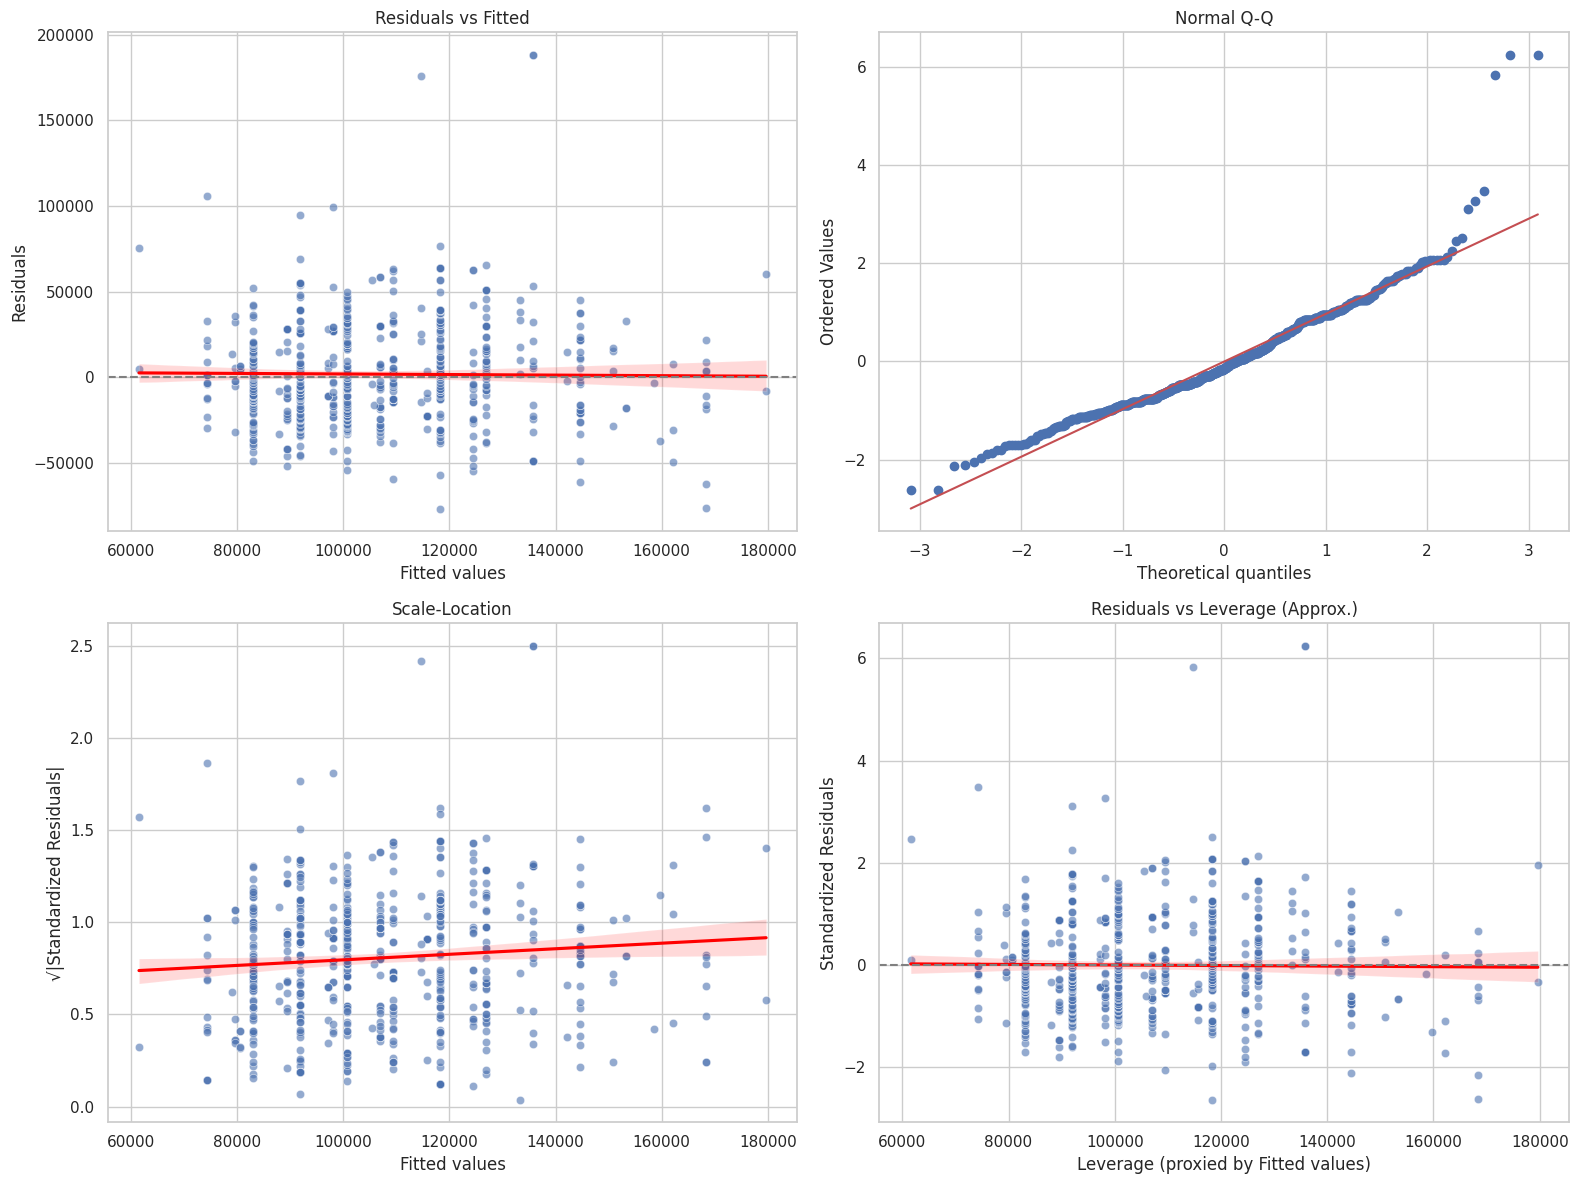

In [34]:
#| eval: true
#| echo: false
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import pandas as pd

# Get predictions from the model
predictions = lr_model.transform(test_data).select("SALARY", "prediction")
predictions_pd = predictions.toPandas()

# Compute residuals and fitted values
predictions_pd["residuals"] = predictions_pd["SALARY"] - predictions_pd["prediction"]
predictions_pd["fitted"] = predictions_pd["prediction"]

# Compute standardized residuals
res_mean = predictions_pd["residuals"].mean()
res_std = predictions_pd["residuals"].std()
predictions_pd["std_residuals"] = (predictions_pd["residuals"] - res_mean) / res_std

# Square root of absolute standardized residuals (for Scale-Location plot)
predictions_pd["sqrt_std_resid"] = np.sqrt(np.abs(predictions_pd["std_residuals"]))

# Set up 2x2 plot grid
plt.figure(figsize=(16, 12))
sns.set_theme(style="whitegrid")

# Plot 1: Residuals vs Fitted
plt.subplot(2, 2, 1)
sns.scatterplot(x="fitted", y="residuals", data=predictions_pd, alpha=0.6)
sns.regplot(x="fitted", y="residuals", data=predictions_pd, scatter=False, color="red")  # No lowess
plt.axhline(0, linestyle='--', color='gray')
plt.title("Residuals vs Fitted")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")

# Plot 2: Normal Q-Q
plt.subplot(2, 2, 2)
stats.probplot(predictions_pd["std_residuals"], dist="norm", plot=plt)
plt.title("Normal Q-Q")

# Plot 3: Scale-Location (√|Standardized Residuals| vs Fitted)
plt.subplot(2, 2, 3)
sns.scatterplot(x="fitted", y="sqrt_std_resid", data=predictions_pd, alpha=0.6)
sns.regplot(x="fitted", y="sqrt_std_resid", data=predictions_pd, scatter=False, color="red")  # No lowess
plt.title("Scale-Location")
plt.xlabel("Fitted values")
plt.ylabel("√|Standardized Residuals|")

# Plot 4: Residuals vs Leverage (approximated with fitted values)
plt.subplot(2, 2, 4)
sns.scatterplot(x="fitted", y="std_residuals", data=predictions_pd, alpha=0.6)
sns.regplot(x="fitted", y="std_residuals", data=predictions_pd, scatter=False, color="red")  # No lowess
plt.axhline(0, linestyle='--', color='gray')
plt.title("Residuals vs Leverage (Approx.)")
plt.xlabel("Leverage (proxied by Fitted values)")
plt.ylabel("Standardized Residuals")

plt.tight_layout()
plt.savefig("_output/glr_diagnostic_classic.png")
plt.show()


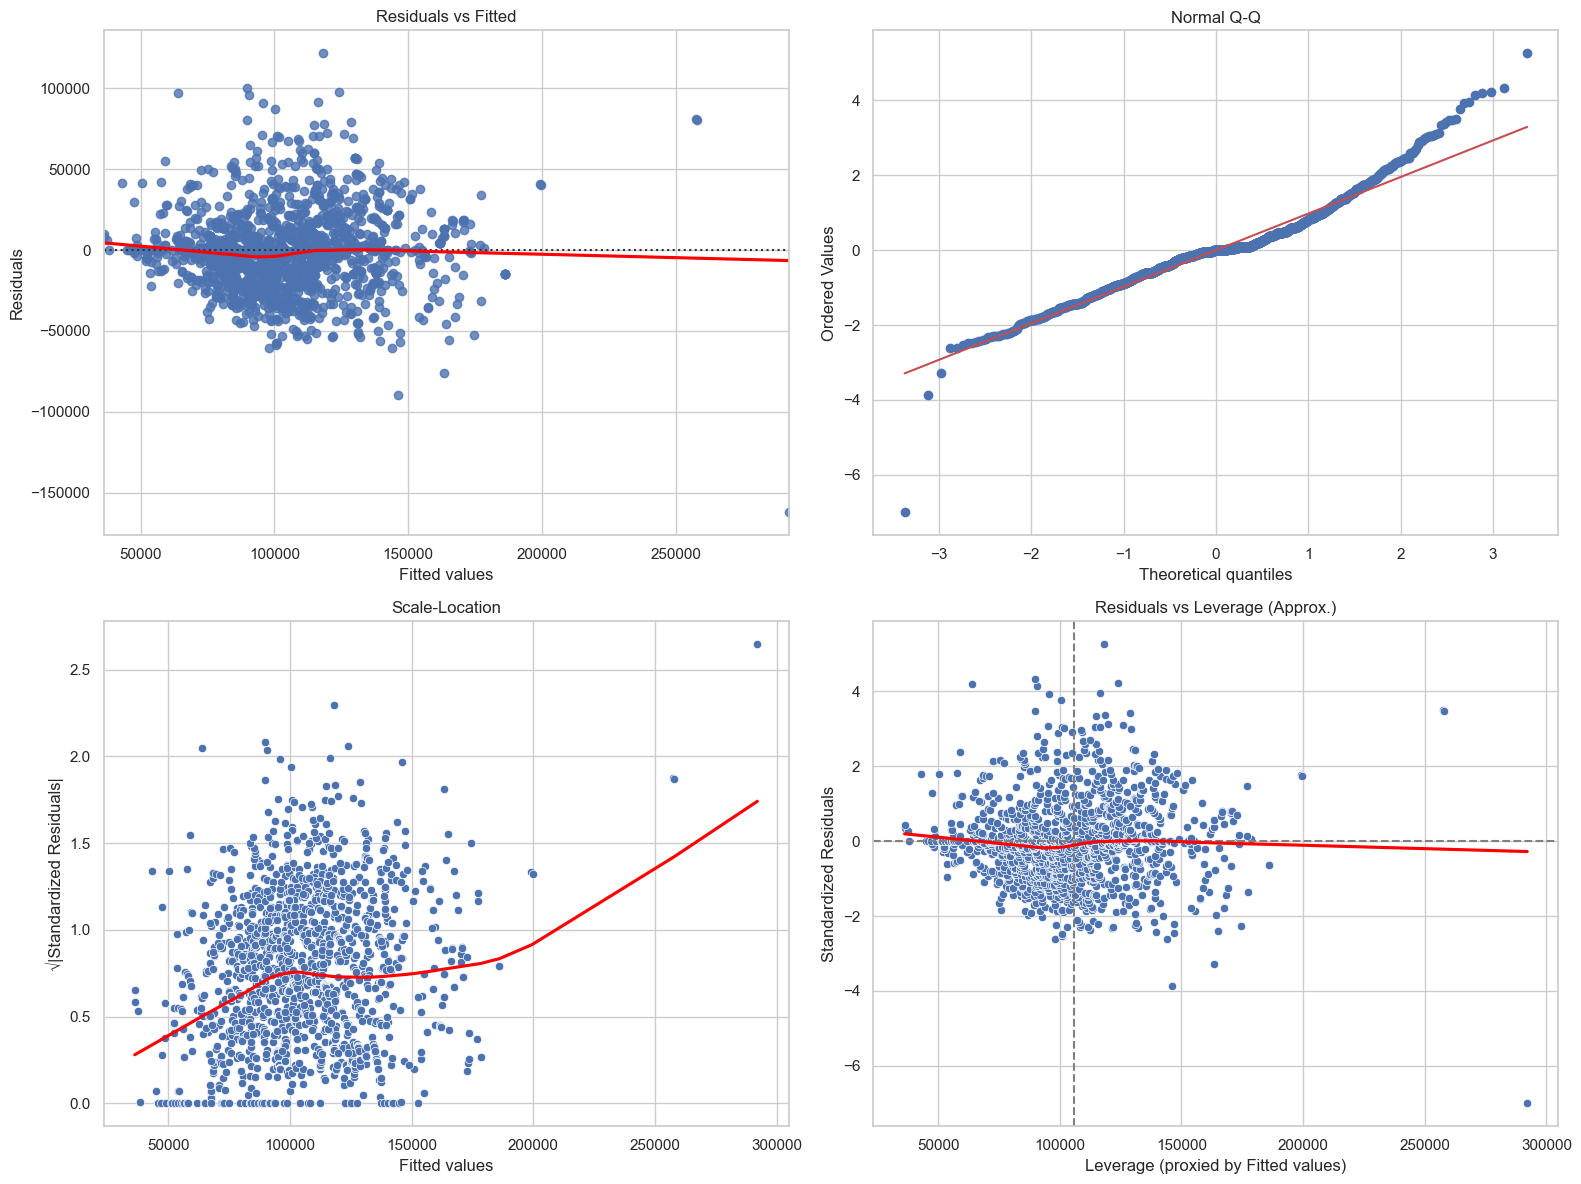

In [ ]:
#| eval: true
#| echo: false
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Load predictions from GLR model
df_pred = summary.predictions.select()

# Compute residuals
df_pred["residuals"] = 
df_pred["fitted"] = 

# Standardized residuals
res_mean = 
res_std = 
df_pred["std_residuals"] = 

# Square root of standardized residuals (for Scale-Location)
df_pred["sqrt_std_resid"] = 


plt.figure(figsize=(16, 12))
sns.set_theme(style="whitegrid")

# Plot 1: Residuals vs Fitted
plt.subplot(2, 2, 1)


# Plot 2: Normal Q-Q
plt.subplot(2, 2, 2)


# Plot 3: Scale-Location
plt.subplot(2, 2, 3)


# Plot 4: Residuals vs Leverage — Approximate
# Note: Leverage & Cook's Distance require X matrix; we approximate using fitted & residual
plt.subplot(2, 2, 4)


plt.tight_layout()
plt.savefig("_output/glr_diagnostic_classic.png")
plt.show()

# Evaluation

The evaluation of the model is crucial to understand its performance. In this section, we will calculate and visualize the following metrics:
1. **R² (Coefficient of Determination)**: Indicates how well the model explains the variance in the target variable.
2. **RMSE (Root Mean Squared Error)**: Measures the average magnitude of the errors between predicted and actual values.

In [13]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, pow, sqrt, avg
import numpy as np

# Predictions on test data
pred_glr = lr_model.transform(test_data)

# R²
r2_eval = RegressionEvaluator(predictionCol="prediction", labelCol="SALARY", metricName="r2")
r2 = r2_eval.evaluate(pred_glr)

# BIC Calculation (manual)
n = pred_glr.count()                              # number of observations
k = len(lr_model.coefficients) + 1                # predictors + intercept

rss = pred_glr.withColumn("squared_error", pow(col("SALARY") - col("prediction"), 2)) \
              .agg({"squared_error": "sum"}).collect()[0][0]

bic = n * np.log(rss / n) + k * np.log(n)

# RMSE (manual)
residuals_df = pred_glr.withColumn("squared_error", pow(col("SALARY") - col("prediction"), 2))
rmse = residuals_df.select(sqrt(avg(col("squared_error")))).first()[0]

# Print results
print("Model Evaluation Metrics:")
print(f"R²: {r2:.4f}")
print(f"BIC: {bic:.2f}")
print(f"RMSE: {rmse:.2f}")


Model Evaluation Metrics:
R²: 0.3128
BIC: 14384.09
RMSE: 29887.21


In [ ]:
#| eval: true
#| echo: false
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, pow, sqrt, avg
import numpy as np

pred_glr = lr_model.transform(test_data)

# R²
r2_eval = 
r2 = 
# AIC from GLR summary
aic = 

# BIC calculation
n = 
k = 
rss = 
bic = 

# RMSE manually
residuals_df = 
rmse = 

## Model Evaluation Plot

- Display the predicted vs actual salary plot with a red line indicating the ideal fit (y=x).
- Use `seaborn` or `matplotlib` to create the plot.
- Customize the plot with appropriate titles, labels, and legends.
- Describe the plot in a few sentences, highlighting key insights and observations.

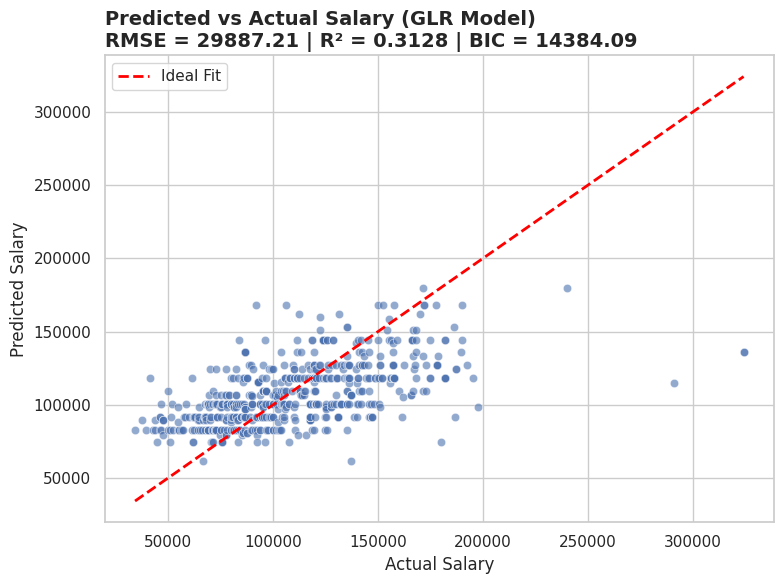

In [40]:
#| eval: true
#| echo: false

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, pow, sqrt, avg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Generate predictions from test data
pred_glr = lr_model.transform(test_data)

# Step 2: Evaluate R² using RegressionEvaluator
r2_eval = RegressionEvaluator(predictionCol="prediction", labelCol="SALARY", metricName="r2")
r2 = r2_eval.evaluate(pred_glr)

# Step 3: Manually calculate RMSE
residuals_df = pred_glr.withColumn("squared_error", pow(col("SALARY") - col("prediction"), 2))
rmse = residuals_df.select(sqrt(avg(col("squared_error")))).first()[0]

# Step 4: Calculate BIC
n = pred_glr.count()                              # Number of observations
k = len(lr_model.coefficients) + 1                # Features + Intercept
rss = residuals_df.agg({"squared_error": "sum"}).collect()[0][0]  # Residual Sum of Squares
bic = n * np.log(rss / n) + k * np.log(n)

# Step 5: Convert predictions to pandas for plotting
pandas_df = pred_glr.select("SALARY", "prediction").toPandas()

# Step 6: Create the plot
plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid")

# Scatter: Actual vs Predicted
sns.scatterplot(x="SALARY", y="prediction", data=pandas_df, alpha=0.6)

# Line: Perfect prediction
plt.plot(
    [pandas_df["SALARY"].min(), pandas_df["SALARY"].max()],
    [pandas_df["SALARY"].min(), pandas_df["SALARY"].max()],
    color='red', linestyle='--', linewidth=2, label="Ideal Fit"
)

# Title with metrics
plt.title(f"Predicted vs Actual Salary (GLR Model)\n"
          f"RMSE = {rmse:.2f} | R² = {r2:.4f} | BIC = {bic:.2f}",
          loc="left", fontsize=14, fontweight="bold")

plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.legend()
plt.tight_layout()

# Save the figure
plt.savefig("_output/glr_predicted_vs_actual.png", dpi=300)
plt.show()


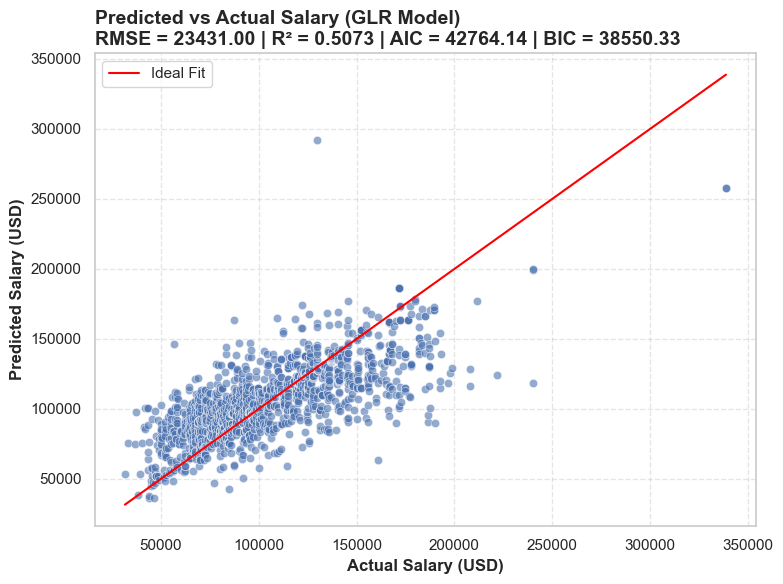

In [ ]:
#| eval: true
#| echo: false
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert GLR predictions to pandas
pandas_df = 

# Plot
plt.figure(figsize=(8, 6))


plt.title(f"Predicted vs Actual Salary (GLR Model)\n"
          f"RMSE = {rmse:.2f} | R² = {r2:.4f} | AIC = {aic:.2f} | BIC = {bic:.2f}", loc="left", fontsize=14, fontweight="bold")

plt.tight_layout()

# Save figure
plt.savefig("_output/glr_predicted_vs_actual.png", dpi=300)
plt.show()

# Submission {.unnumbered}
1. Save figures in the `_output/` folder.
2. Commit and push code and output files:
```bash
git add .
git commit -m "Add Lab 08 Salary Prediction models and output"
git push origin main
```
3. Submit your GitHub repository link.

# Resources {.unnumbered}
- [PySpark MLlib Docs](https://spark.apache.org/docs/latest/ml-guide.html)  
- [Seaborn Docs](https://seaborn.pydata.org/)  
- [Pandas User Guide](https://pandas.pydata.org/docs/user_guide/index.html)
